# data

> data module to generate test data

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
#| default_exp alg.vae

In [44]:
#| hide
from nbdev.showdoc import *

In [45]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn.functional import binary_cross_entropy


In [46]:
#| explort
# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 400)  # Input shape: [batch_size, 784] -> Output: [batch_size, 400]
        self.fc_mu = nn.Linear(400, latent_dim)  # Input shape: [batch_size, 400] -> Output: [batch_size, latent_dim]
        self.fc_logvar = nn.Linear(400, latent_dim)  # Input shape: [batch_size, 400] -> Output: [batch_size, latent_dim]
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Flatten input: [batch_size, 1, 28, 28] -> [batch_size, 784]
        x = torch.relu(self.fc1(x))  # Pass through fc1: [batch_size, 784] -> [batch_size, 400]
        mu = self.fc_mu(x)  # Compute mean: [batch_size, 400] -> [batch_size, latent_dim]
        logvar = self.fc_logvar(x)  # Compute log variance: [batch_size, 400] -> [batch_size, latent_dim]
        return mu, logvar

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 400)  # Input shape: [batch_size, latent_dim] -> Output: [batch_size, 400]
        self.fc2 = nn.Linear(400, 28 * 28)  # Input shape: [batch_size, 400] -> Output: [batch_size, 784]
    
    def forward(self, z):
        z = torch.relu(self.fc1(z))  # Pass through fc1: [batch_size, latent_dim] -> [batch_size, 400]
        z = torch.sigmoid(self.fc2(z))  # Pass through fc2: [batch_size, 400] -> [batch_size, 784]
        return z.view(-1, 1, 28, 28)  # Reshape: [batch_size, 784] -> [batch_size, 1, 28, 28]

# Define the VAE
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Compute standard deviation: [batch_size, latent_dim]
        eps = torch.randn_like(std)  # Sample from standard normal: [batch_size, latent_dim]
        return mu + eps * std  # Reparameterize: [batch_size, latent_dim]
    
    def forward(self, x):
        mu, logvar = self.encoder(x)  # Encode input: [batch_size, 1, 28, 28] -> mu/logvar: [batch_size, latent_dim]
        z = self.reparameterize(mu, logvar)  # Sample latent vector: [batch_size, latent_dim]
        x_reconstructed = self.decoder(z)  # Decode latent vector: [batch_size, latent_dim] -> [batch_size, 1, 28, 28]
        return x_reconstructed, mu, logvar


In [47]:
# Hyperparameters
batch_size = 128
learning_rate = 1e-3
latent_dim = 20
epochs = 10

# Data Preparation
# ERROR: in add ing Normalize
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Loss Function
# ERROR: either no normalization, or mse error
def loss_function(reconstructed_x, x, mu, logvar):
    BCE = binary_cross_entropy(reconstructed_x, x, reduction='sum')  # Reconstruction loss: [batch_size, 1, 28, 28] -> scalar
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence: [batch_size, latent_dim] -> scalar
    return BCE + KLD, BCE, KLD

# Model, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    total_bce_loss = 0
    total_kld_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed_data, mu, logvar = model(data)
        loss, bce_loss, kld_loss = loss_function(reconstructed_data, data, mu, logvar)
        train_loss += loss.item()
        total_bce_loss += bce_loss.item()
        total_kld_loss += kld_loss.item()
        # print(f"{batch_idx}: {train_loss:.4f} {total_bce_loss:.4f} {total_kld_loss:.4f}")
        
        loss.backward()
        optimizer.step()
    
    size = len(train_loader.dataset)
    avg_loss = train_loss / size
    avg_bce_loss = total_bce_loss / size
    avg_kld_loss = total_kld_loss / size
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f} \
          bce: {avg_bce_loss:.4f} kld loss: {avg_kld_loss:.4f}")

Epoch 1, Loss: 163.9387           bce: 148.1123 kld loss: 15.8264
Epoch 2, Loss: 120.9847           bce: 98.4182 kld loss: 22.5665
Epoch 3, Loss: 114.1537           bce: 90.0331 kld loss: 24.1205
Epoch 4, Loss: 111.2663           bce: 86.5859 kld loss: 24.6804
Epoch 5, Loss: 109.5932           bce: 84.6633 kld loss: 24.9299
Epoch 6, Loss: 108.4874           bce: 83.3896 kld loss: 25.0979
Epoch 7, Loss: 107.6105           bce: 82.4498 kld loss: 25.1607
Epoch 8, Loss: 106.9707           bce: 81.7278 kld loss: 25.2429
Epoch 9, Loss: 106.4931           bce: 81.2061 kld loss: 25.2870
Epoch 10, Loss: 106.0744           bce: 80.7419 kld loss: 25.3325


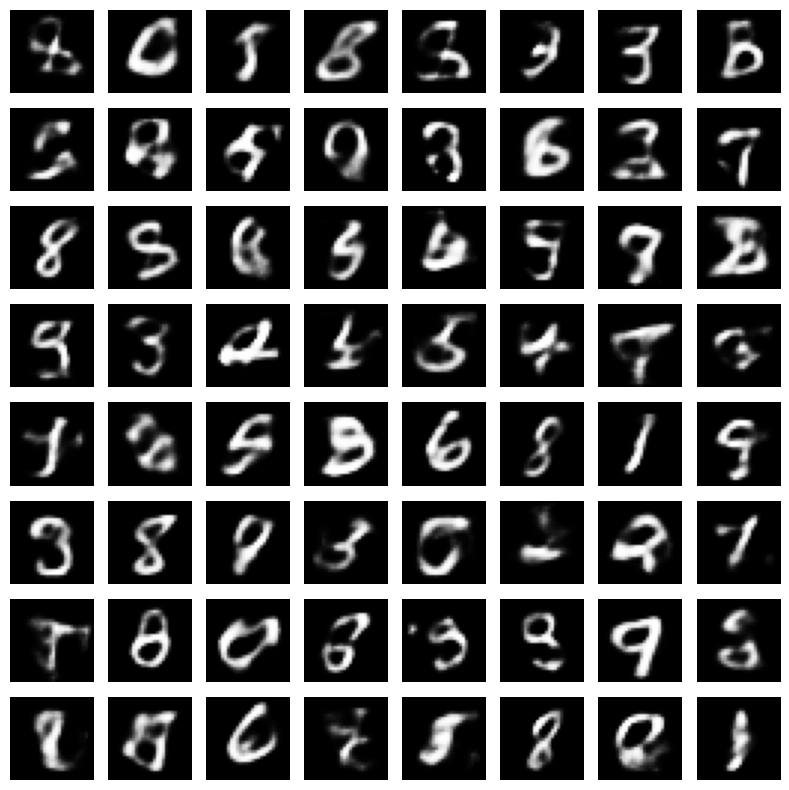

In [ ]:
# Visualizing Results
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    sample = torch.randn(64, latent_dim).to(device)
    generated_images = model.decoder(sample).cpu()

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i, 0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [41]:
#| hide
import nbdev; nbdev.nbdev_export()